In [14]:
%cd /data/soyeonhong/vq2d/vq2d-lightning

from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import json
from pprint import pformat

from ltvu.metrics import *

/data/soyeonhong/vq2d/vq2d-lightning


In [15]:
p_ann = Path("data/vq_v2_val_anno.json")
p_preds = {
    # '33596_no_conv': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/ckpts/33596/predictions.json"),
    # '134100_only_conv': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/batch/2024-10-23/134100/predictions.json"),
    # '134830_global_STTX': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/batch/2024-10-25/134830/predictions.json"),
    # '135395_Ours': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/batch/2024-10-28/135395/predictions.json"),
    '57242_Ours': Path("/data/soyeonhong/vq2d/vq2d-lightning/outputs/predictions/57242_predictions.json"),
    '135921_conv': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/batch/2024-10-30/135921/predictions.json"),
    # '135922_global_STTX': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/batch/2024-10-30/135922/predictions.json"),
    # '135920_baseline': Path("/data/gunsbrother/repos/vq2d-lightning/outputs/debug/2024-11-01/136609/predictions.json"),
    # '34179_cls_guide': Path("/data/soyeonhong/vq2d/vq2d-lightning/outputs/predictions_34179.json"),
    # '34180_pca_guide': Path("/data/soyeonhong/vq2d/vq2d-lightning/outputs/predictions_34180.json"),
    # '57243_hqq': Path('/data/soyeonhong/vq2d/vq2d-lightning/outputs/predictions_57243.json'),
    # 'VQLoC': Path("/data/gunsbrother/repos/vq2d-lightning/notebooks/43634_results.json.gz"),
    # "VQLoC": Path("/data/soyeonhong/repo/VQLoC/output/ego4d_vq2d/val/validate/inference_cache_val_results.json.gz")
}
all_anns = json.load(p_ann.open())

In [16]:
def calculate_diff(x1, x2, y1, y2, w1, w2, h1, h2, ori_w, ori_h, mode = 'add'):
    x1 = max(x1, 0)
    x2 = max(x2, 0)
    y1 = max(y1, 0)
    y2 = max(y2, 0)
    w1 = max(w1, 0)
    w2 = max(w2, 0)
    h1 = max(h1, 0)
    h2 = max(h2, 0)
    x_diff = (x2 - x1) / ori_w
    y_diff = (y2 - y1) / ori_h
    w_diff = (w2 - w1) / ori_w
    h_diff = (h2 - h1) / ori_h
    
    position_diff = (x_diff ** 2 + y_diff ** 2) ** 0.5
    size_diff = (w_diff ** 2 + h_diff ** 2) ** 0.5
    if mode == 'add':
        all_diff = position_diff + size_diff
    elif mode == 'add2':
        all_diff = (x_diff ** 2 + y_diff ** 2 + w_diff ** 2 + h_diff ** 2) ** 0.5
    elif mode == 'mul':
        all_diff = position_diff * size_diff
    elif mode == 'harmonic_mean':
        area1 = w1 * h1
        area2 = w2 * h2
        area_hm = 2 * area1 * area2 / (area1 + area2 + 1e-6) 
        
        # Normalize changes by image dimensions if applicable
        x_diff = (x2 - x1) / (area_hm ** 0.5 + 1e-6)
        y_diff = (y2 - y1) / (area_hm ** 0.5 + 1e-6)
        w_diff = (w2 - w1) / (area_hm ** 0.5 + 1e-6)
        h_diff = (h2 - h1) / (area_hm ** 0.5 + 1e-6)
    elif mode == 'use_log':
        x_diff = np.log(1 + x2 / (x1 + 1e-6))
        y_diff = np.log(1 + y2 / (y1 + 1e-6))
        w_diff = np.log(1 + w2 / (w1 + 1e-6))
        h_diff = np.log(1 + h2 / (h1 + 1e-6))
        
        all_diff = np.abs(x_diff) + np.abs(y_diff) + np.abs(w_diff) + np.abs(h_diff)
    elif mode == 'l1_distance':
        w_diff = np.log(w2 / w1)
        h_diff = np.log(h2 / h1)
        
        all_diff = np.abs(x_diff) + np.abs(y_diff) + np.abs(w_diff) + np.abs(h_diff)
    elif mode == 'l1_distance2':
        all_diff = np.abs(x_diff) + np.abs(y_diff) + np.abs(w_diff) + np.abs(h_diff)    
    elif mode == 'l2_distance':
        w_diff = np.log(w2 / w1)
        h_diff = np.log(h2 / h1)
        all_diff = (x_diff ** 2 + y_diff ** 2 + w_diff ** 2 + h_diff ** 2) ** 0.5
        
    
    return all_diff

In [17]:
def compute_variation_threshold(all_anns, percentile = 70, mode = 'add'):
    all_diffs = []
    for ann in all_anns:
        
        if len(ann['response_track']) <= 1:
            continue

        ori_w = ann['original_width']
        ori_h = ann['original_height']

        temp_all_diffs = []            
        for idx in range(len(ann['response_track']) - 1):
            rt1 = ann['response_track'][idx]
            rt2 = ann['response_track'][idx + 1]
            
            # Extract bounding box coordinates
            x1, y1, w1, h1 = rt1['x'], rt1['y'], rt1['w'], rt1['h']
            x2, y2, w2, h2 = rt2['x'], rt2['y'], rt2['w'], rt2['h']
            
            if w1 == 0 or h1 == 0 or w2 == 0 or h2 == 0:
                continue

            all_diff = calculate_diff(x1, x2, y1, y2, w1, w2, h1, h2, ori_w, ori_h, mode)

            temp_all_diffs.append(all_diff)
        
        all_diffs.append(float(np.mean(temp_all_diffs)))
        
    threshold = np.percentile(all_diffs, percentile)
    
    return threshold

def get_metrics(p_ann_flat, p_pred, threshold, threshold2, mode = 'default', diff_mode = 'add'):
    variation_qset_uuid = {}
    p_ann_flat = Path(p_ann_flat)
    p_pred = Path(p_pred)
    all_anns_flat = json.load(p_ann_flat.open())
    all_preds_stratified = json.load(p_pred.open())

    quid2pred, quid2pos = defaultdict(list), {}
    for ann in all_anns_flat:
        qset_uuid = f'{ann["annotation_uid"]}_{ann["query_set"]}'
        if mode == 'box_variation':
            ori_w = ann['original_width']
            ori_h = ann['original_height']
            

            all_diffs = []

            for idx in range(len(ann['response_track']) - 1):
                rt1 = ann['response_track'][idx]
                rt2 = ann['response_track'][idx + 1]
                
                # Extract bounding box coordinates
                x1, y1, w1, h1 = rt1['x'], rt1['y'], rt1['w'], rt1['h']
                x2, y2, w2, h2 = rt2['x'], rt2['y'], rt2['w'], rt2['h']
                
                if w1 == 0 or h1 == 0 or w2 == 0 or h2 == 0:
                    continue
                
                all_diff = calculate_diff(x1, x2, y1, y2, w1, w2, h1, h2, ori_w, ori_h, diff_mode)

                all_diffs.append(all_diff)
            
            if threshold < np.mean(all_diffs) <= threshold2:
                ann['bboxes'] = ResponseTrack.from_json(ann)
                quid2pos[qset_uuid] = ann['bboxes']
                variation_qset_uuid[qset_uuid] = {'object_title': ann['object_title'],
                                                  'video_uid': ann['video_uid'],}
                
                
        else:
            ann['bboxes'] = ResponseTrack.from_json(ann)
            quid2pos[qset_uuid] = ann['bboxes']        

    for pred_video in all_preds_stratified['results']['videos']:
        video_uid = pred_video['video_uid']
        for pred_clip in pred_video['clips']:
            clip_uid = pred_clip['clip_uid']
            for pred_qsets in pred_clip['predictions']:
                annotation_uid = pred_qsets['annotation_uid']
                for qset_id, qset in pred_qsets['query_sets'].items():
                    qset_uuid = f'{annotation_uid}_{qset_id}'
                    if qset_uuid in quid2pos:
                        quid2pred[qset_uuid].append(ResponseTrack.from_json(qset))

    quid2pos = {quid: pos for quid, pos in quid2pos.items()}
    quid2pred = {quid: pred for quid, pred in quid2pred.items()}

    tious: dict[str, float] = compute_tious(quid2pred, quid2pos)
    stious: dict[str, float] = compute_stious(quid2pred, quid2pos)
    all_sious, all_areas = compute_sious_for_positives(quid2pred, quid2pos)
    all_max_areas = {quid: max(areas) for quid, areas in all_areas.items()}

    # subsample GT samples based on their max bbox area of each RT
    subset_max_bbox_area_ranges_base = {
        'all':    (0, np.inf),
        'large':  (96 ** 2, np.inf),
        'medium': (32 ** 2, 96 ** 2),
        'small':  (0, 32 ** 2),
    }
    input_area_base = 224 ** 2
    input_area = 448 ** 2
    mul = input_area / input_area_base
    subset_max_bbox_area_ranges = {k: (mul*v[0], mul*v[1]) for k, v in subset_max_bbox_area_ranges_base.items()}

    # theoretically, python >3.5 dicts keep insertion order but sort it for safety
    all_quids_in_order = sorted(set(quid2pos.keys()))
    tious_arr = np.array([tious[quid] for quid in all_quids_in_order])
    stious_arr = np.array([stious[quid] for quid in all_quids_in_order])
    all_sious_arr = np.array([all_sious[quid] for quid in all_quids_in_order], dtype=list)  # flattened
    all_max_areas_arr = np.array([all_max_areas[quid] for quid in all_quids_in_order], dtype=list)  # flattened

    subset_metrics = {}
    for subset_name, (lbd, ubd) in subset_max_bbox_area_ranges.items():
        
        max_area_mask = (lbd <= all_max_areas_arr) & (all_max_areas_arr < ubd)
        tap_dict = compute_average_precision_dict(tious_arr[max_area_mask])
        stap_dict = compute_average_precision_dict(stious_arr[max_area_mask])
        sap_dict = compute_average_precision_dict(np.array(sum(all_sious_arr[max_area_mask], [])), thresholds=[.5])
        succ_dict = compute_average_precision_dict(stious_arr[max_area_mask], thresholds=[.05])
        rec_dict = compute_average_precision_dict(tious_arr[max_area_mask], thresholds=[.3, .5])

        # tap = tap_dict['mAP']
        # tap25 = tap_dict['APs'][0]["AP"]
        stap = stap_dict['mAP']
        stap25 = stap_dict['APs'][0]["AP"]
        # rec = sap_dict['recalls'][-1, -1]
        # succ = succ_dict['precisions'][-1, -1]
        # r1_03 = rec_dict['recalls'][0, -1]
        # r1_05 = rec_dict['recalls'][1, -1]

        subset_metrics[subset_name] = {
            'subset_info': {
                'lbd': lbd,
                'ubd': ubd,
                'max_area_mask': max_area_mask,
            },
            'metrics': {
                # 'tap': tap,
                # 'taps': tap25,
                'stap': stap,
                'staps': stap25,
                # 'rec': rec,
                # 'succ': succ,
                # 'r1_03': r1_03,
                # 'r1_05': r1_05,
            }
        }

    return subset_metrics, variation_qset_uuid

In [20]:
eval_results_all = {}
variation_qset_uuid_all = {}
# mode = 'l1_distance2'
# mode = 'mul'
mode = 'l2_distance'

for percentile in range(0, 100, 10):
    print(f"Percentile: {percentile} ~ {percentile+10}")
    # print(f'Percentile: {percentile}')
    threshold1 = compute_variation_threshold(all_anns, percentile, mode)
    threshold2 = compute_variation_threshold(all_anns, percentile+10, mode)
    print(f"thresholds: {round(threshold1, 3)}, {round(threshold2, 3)}")
    for idx, model_name in enumerate(list(p_preds.keys())):
        p_pred = p_preds[model_name]
        metrics, variation_qset_uuid_list = get_metrics(p_ann, p_pred, threshold1, threshold2, mode = 'box_variation', diff_mode = mode)
        metrics = metrics['all']['metrics']
        staps = metrics['staps']
        
        if model_name not in eval_results_all:
            eval_results_all[model_name] = [staps]
        else:
            eval_results_all[model_name].append(staps)

Percentile: 0 ~ 10
thresholds: 0.0, 0.125


/data/soyeonhong/anaconda3/envs/vq2d-lightning/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/soyeonhong/anaconda3/envs/vq2d-lightning/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Percentile: 10 ~ 20
thresholds: 0.125, 0.172
Percentile: 20 ~ 30
thresholds: 0.172, 0.209
Percentile: 30 ~ 40
thresholds: 0.209, 0.246
Percentile: 40 ~ 50
thresholds: 0.246, 0.29
Percentile: 50 ~ 60
thresholds: 0.29, 0.343
Percentile: 60 ~ 70
thresholds: 0.343, 0.41
Percentile: 70 ~ 80
thresholds: 0.41, 0.504
Percentile: 80 ~ 90
thresholds: 0.504, 0.662
Percentile: 90 ~ 100
thresholds: 0.662, 3.342


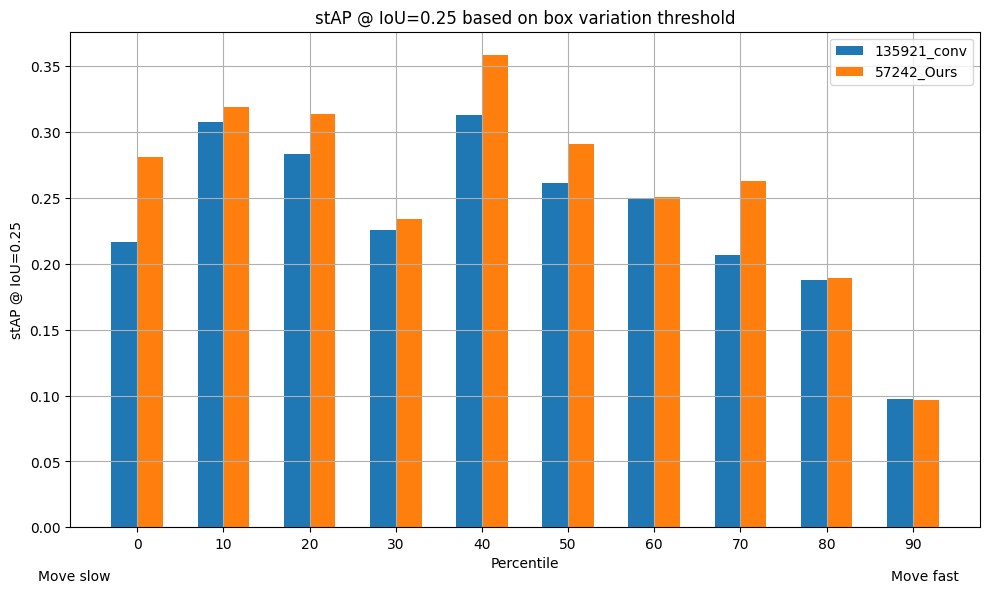

In [21]:
# ['134830_global_STTX', '135395_Ours', '57242_Ours', '135921_conv', '135922_global_STTX', '135920_baseline', '34179_cls_guide', '34180_pca_guide', '57243_hqq']

# pred_model = ['135921_conv', '135922_global_STTX']
# pred_model = ['135920_baseline', '57242_Ours']
# pred_model = ['135920_baseline', '34179_cls_guide']
# pred_model = ['135920_baseline', '34180_pca_guide']
# pred_model = ['135920_baseline', '57243_hqq']
pred_model = [ '135921_conv', '57242_Ours',]
# pred_model = ['135920_baseline', '135921_conv']
# pred_model = ['VQLoC', '57242_Ours']
percentiles = np.arange(0, 100, 10)
width = 3

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the bar charts
ax1.bar(percentiles, eval_results_all[pred_model[0]], label=pred_model[0], color='tab:blue', width=width)
ax1.bar(percentiles + width, eval_results_all[pred_model[1]], label=pred_model[1], color='tab:orange', width=width)
ax1.set_xlabel('Percentile')
ax1.set_ylabel('stAP @ IoU=0.25')
ax1.set_title('stAP @ IoU=0.25 based on box variation threshold')
ax1.set_xticks(percentiles + width / 2)
ax1.set_xticklabels(percentiles)
ax1.grid(True)
ax1.legend(loc='upper right')

# Create a secondary y-axis for the difference line plot
# ax2 = ax1.twinx()
# difference = np.array(eval_results_all[key2]) - np.array(eval_results_all[key1])
# ax2.plot(percentiles + width / 2, difference, label=f'Difference({key2}_{legend2} - {key1}_{legend1})', marker='o', color='tab:orange')
# ax2.set_ylabel('Difference')
# ax2.tick_params(axis='y')
# ax2.legend(loc='best')

# Add move slow and move fast labels
plt.text(-10,-0.04, 'Move slow')
plt.text(89, -0.04, 'Move fast')

fig.tight_layout()  # Adjust layout to make room for the secondary y-axis
plt.show()

### Box Variation Sample

In [31]:
quid2ann = {}
percentile = 90
mode = 'l1_distance'
threshold1 = compute_variation_threshold(all_anns, percentile, mode)
threshold2 = compute_variation_threshold(all_anns, percentile+10, mode)
print(f"thresholds: {round(threshold1, 3)}, {round(threshold2, 3)}")
for ann in all_anns:
    quid = f'{ann["annotation_uid"]}_{ann["query_set"]}'
    
    ori_w = ann['original_width']
    ori_h = ann['original_height']
    

    all_diffs = []

    for idx in range(len(ann['response_track']) - 1):
        rt1 = ann['response_track'][idx]
        rt2 = ann['response_track'][idx + 1]
        
        # Extract bounding box coordinates
        x1, y1, w1, h1 = rt1['x'], rt1['y'], rt1['w'], rt1['h']
        x2, y2, w2, h2 = rt2['x'], rt2['y'], rt2['w'], rt2['h']
        
        if w1 == 0 or h1 == 0 or w2 == 0 or h2 == 0:
            continue
        
        all_diff = calculate_diff(x1, x2, y1, y2, w1, w2, h1, h2, ori_w, ori_h, mode)

        all_diffs.append(all_diff)
    
    if threshold1 < np.mean(all_diffs) <= threshold2:
        quid2ann[quid] = ann
        quid2ann[quid]['difference'] =  np.mean(all_diffs)

thresholds: 0.948, 4.75


In [32]:
from pathlib import Path
from collections import defaultdict
import numpy as np
import json

import sys
sys.path.append('/data/gunsbrother/repos/vq2d-lightning')
from ltvu.structures import ResponseTrack


# clip level
def compute_tious(all_preds: dict[list[ResponseTrack]], all_pos: dict[ResponseTrack]):
    """
    Bboxes are in the format of xyhw, aspect to the input clip size.

    Parameters
    ----------
    all_preds : qset_uuid -> list of predicted response tracks
    gts : qset_uuid -> GT response track
    """
    all_qset_uuids = set(all_preds.keys())
    assert all_qset_uuids == set(all_pos.keys())
    all_qset_uuids = sorted(all_qset_uuids)

    tious = {}
    for qset_uuid in all_qset_uuids:
        pos_rt = all_pos[qset_uuid]
        pred_rt = max(all_preds[qset_uuid], key=lambda rt: rt.score)  # highest score
        pos_ext, pred_ext = pos_rt.temporal_extent, pred_rt.temporal_extent
        tinter = pos_ext.intersection(pred_ext)
        tunion = pos_ext.union(pred_ext)
        tiou = tinter / tunion
        tious[qset_uuid] = tiou
    return tious


# clip level
def compute_stious(all_preds: dict[list[ResponseTrack]], all_pos: dict[ResponseTrack]):
    all_qset_uuids = set(all_preds.keys())
    assert all_qset_uuids == set(all_pos.keys())
    all_qset_uuids = sorted(all_qset_uuids)

    stious = {}
    for qset_uuid in all_qset_uuids:
        pos_rt = all_pos[qset_uuid]
        pred_rt = max(all_preds[qset_uuid], key=lambda rt: rt.score)  # highest score
        stinter = pos_rt.intersection(pred_rt)
        stunion = pos_rt.union(pred_rt)
        stiou = stinter / stunion
        stious[qset_uuid] = stiou
    return stious


# frame level
def compute_sious_for_positives(all_preds: dict[list[ResponseTrack]], all_pos: dict[ResponseTrack]):
    all_qset_uuids = set(all_preds.keys())
    assert all_qset_uuids == set(all_pos.keys())
    all_qset_uuids = sorted(all_qset_uuids)

    all_sious: dict[str, list[float]] = defaultdict(list)  # qset_uuid -> list of sious for each GT frame
    all_areas: dict[str, list[float]] = defaultdict(list)  # qset_uuid -> list of areas for each GT frame
    for qset_uuid in all_qset_uuids:
        pos_rt = all_pos[qset_uuid]
        pred_rt = max(all_preds[qset_uuid], key=lambda rt: rt.score)  # highest score
        pos_ext, pred_ext = pos_rt.temporal_extent, pred_rt.temporal_extent
        for fno in pos_ext:
            pos_bbox = pos_rt[fno]
            pred_bbox = pred_rt.get(fno)
            sinter = pos_bbox.intersection(pred_bbox)
            sunion = pos_bbox.union(pred_bbox)
            if sunion == 0:
                print(qset_uuid, pos_bbox, pred_bbox)
            siou = sinter / sunion
            all_sious[qset_uuid].append(siou)
            all_areas[qset_uuid].append(pos_bbox.area)
    return all_sious, all_areas  # all sious for positives, all areas for positives


59b6fea9-77fa-4360-8bef-d14ab6ecb7d1 431d5d3d-7ab8-40c8-8fdd-dd54e50a3cc5_1
1920 1440
(598, 448)
bucket
{'fno': 955, 'x': 25.32133333333333, 'y': 17.50311111111111, 'w': 107.5511111111111, 'h': 99.456}
{'x': 0.013188194444444443, 'y': 0.012154938271604937, 'w': 0.0560162037037037, 'h': 0.06906666666666667}


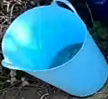

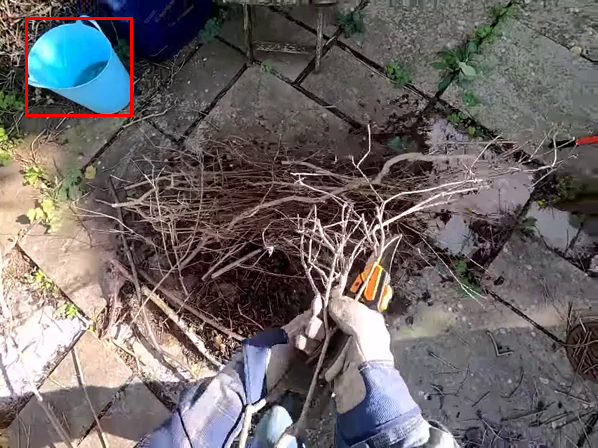

Pred frames: 936 ~ 940
GT frames: 936 ~ 940
mean sqrt area : 195.41 px
move variation:  1.403


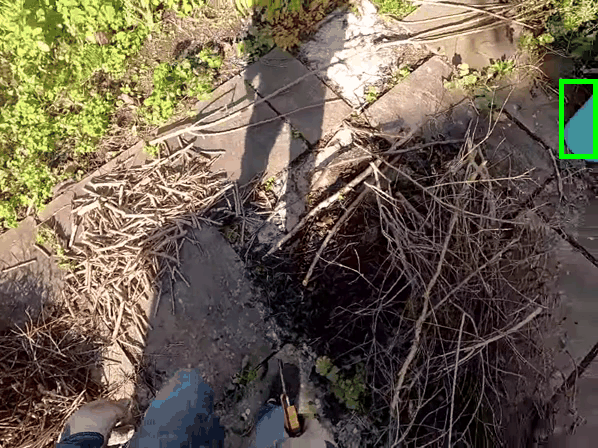

In [34]:
from PIL import Image, ImageDraw, ImageOps, ImageFont
from decord import VideoReader
import numpy.random
from IPython.display import Image as IPImage

def get_pillow_images(p_clip, idxs):
    peal = False
    if isinstance(idxs, int):
        idxs = [idxs]
        peal = True
    vr = VideoReader(str(p_clip), num_threads=0)
    frames = vr.get_batch(idxs).asnumpy()
    frames = [Image.fromarray(f) for f in frames]
    if peal:
        return frames[0]
    else:
        return frames

def draw_boxes_on_images(images, boxes, color='red', width=3):
    peal = False
    if not isinstance(boxes, list):
        boxes = [boxes]
        peal = True
    if not isinstance(images, list):
        images = [images]
        peal = True
    for img, box in zip(images, boxes):
        draw = ImageDraw.Draw(img)
        x, y, w, h = box['x'], box['y'], box['w'], box['h']
        draw.rectangle([(x, y), (x+w, y+h)], outline=color, width=width)
    if peal:
        return images[0]
    else:
        return images

def combine_image_lists_with_padding_and_text(list1, list2, q, margin=0, padding=20, padding_color=(255, 255, 255), top_margin=100, text=None, obj=None):
    # Check if the image sizes are the same
    width, height = list1[0].size
    if any(img.size != (width, height) for img in list1 + list2):
        raise ValueError('All images must have the same size.')

    # Get the length of the longest list
    max_length = max(len(list1), len(list2))

    # Apply padding to images
    def add_padding(image):
        return ImageOps.expand(image, border=padding, fill=padding_color)

    # Repeat the shorter list if necessary
    combined_images = []
    for i in range(max_length):
        img1 = list1[i % len(list1)]  # Repeat list1 if it's shorter
        img2 = list2[i % len(list2)]  # Repeat list2 if it's shorter

        # Add padding to both images
        img1_padded = add_padding(img1)
        img2_padded = add_padding(img2)
        q_padded = add_padding(q)

        # Get new dimensions after padding
        padded_width, padded_height = img1_padded.size

        # Create a new image with a white background to serve as margin and text space
        combined_img = Image.new('RGB', (padded_width * 3 + margin * 2, padded_height + top_margin), (255, 255, 255))

        # Draw text at the top margin if provided
        draw = ImageDraw.Draw(combined_img)
        font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", 16, encoding="unic")
        if text:
            draw.text((padding, padding), text, fill=(0, 0, 0), font=font)
        if obj:
            draw.text((padded_width * 2.5 + margin * 2, top_margin - 20), obj, fill=(0, 0, 0), font=font, align='center')

        # Paste the padded images below the text
        combined_img.paste(img1_padded, (0, top_margin))
        combined_img.paste(img2_padded, (padded_width + margin, top_margin))
        combined_img.paste(q_padded, (padded_width * 2 + margin * 2, top_margin))

        combined_images.append(combined_img)

    return combined_images

################################################################################

p_clips_dir = Path('/data/datasets/ego4d_data/v2/vq2d_clips/448ss')

quids = sorted(quid2ann.keys())
num_quids = len(quids)
quid = quids[np.random.choice(num_quids)]

clip_uid = quid2info[quid]['clip_uid']
pred_bboxes = quid2pred[quid]['bboxes']
gt_rt = quid2ann[quid]['response_track']
vc = quid2ann[quid]['visual_crop'].copy()
ann = quid2ann[quid]
ow, oh = ann['original_width'], ann['original_height']
obj = ann['object_title']



p_clip = p_clips_dir / f'{clip_uid}.mp4'
if p_clips_dir.stem == 'clips':
    vc['fno'] *= 6

################################################################################
# get query image and display

query = get_pillow_images(p_clip, vc['fno'])
rho = oh / query.size[1]
query_crop = query.crop((vc['x']/rho, vc['y']/rho, (vc['x']+vc['w'])/rho, (vc['y']+vc['h'])/rho))
vc['x'], vc['y'], vc['w'], vc['h'] = vc['x'] / rho, vc['y'] / rho, vc['w'] / rho, vc['h'] / rho
query = draw_boxes_on_images(query, vc)
print(clip_uid, quid)
print(ow, oh)
print(query.size)
print(obj)
print(vc)
print({'x': vc['x'] / ow, 'y': vc['y'] / oh, 'w': vc['w'] / ow, 'h': vc['h'] / oh})
display(query_crop)
display(query)

################################################################################
# get pred frames

fnos = [bbox['fno'] for bbox in pred_bboxes]
pred_frames = get_pillow_images(p_clip, fnos)
gt_frames = get_pillow_images(p_clip, [gt['fno'] for gt in gt_rt])
gt_ext = gt_rt[0]["fno"], gt_rt[-1]["fno"]
print(f'Pred frames: {fnos[0]} ~ {fnos[-1]}')
print(f'GT frames: {gt_ext[0]} ~ {gt_ext[-1]}')

################################################################################
# GT on pred frames

# draw pred
bboxes_pred = []
for bbox in quid2pred[quid]['bboxes']:
    bbox = bbox.copy()
    x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
    bbox['x'], bbox['y'], bbox['w'], bbox['h'] = x / rho, y / rho, w / rho, h / rho
    bboxes_pred.append(bbox)
pred_frames = draw_boxes_on_images(pred_frames, bboxes_pred)

# draw GT
bboxes_gt = []
tmp = quid2ann[quid]['response_track']
# sync_offset = fnos.index(tmp['fno']) if tmp['fno'] in fnos else int(1e6)
sync_offset = tmp[0]['fno'] - fnos[0]
if sync_offset >= 0:  # GT is later than pred -> pad first sync_offset frames
    bboxes_gt += [{'x': 0, 'y': 0, 'w': 0, 'h': 0} for _ in range(sync_offset)]
    for bbidx, bbox in enumerate(tmp):
        bbox = bbox.copy()
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        bbox['x'], bbox['y'], bbox['w'], bbox['h'] = x / rho, y / rho, w / rho, h / rho
        bboxes_gt.append(bbox)
else:  # GT is ahead of pred -> skip first sync_offset GT frames
    for bbidx, bbox in enumerate(tmp[-sync_offset:]):
        bbox = bbox.copy()
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        bbox['x'], bbox['y'], bbox['w'], bbox['h'] = x / rho, y / rho, w / rho, h / rho
        bboxes_gt.append(bbox)
    bboxes_gt += [{'x': 0, 'y': 0, 'w': 0, 'h': 0} for _ in range(-sync_offset)]
pred_frames = draw_boxes_on_images(pred_frames, bboxes_gt, color=(0, 255, 0))

################################################################################
# GT frames

bboxes_gt = []
for bbox in quid2ann[quid]['response_track']:
    bbox = bbox.copy()
    x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
    bbox['x'], bbox['y'], bbox['w'], bbox['h'] = x / rho, y / rho, w / rho, h / rho
    bboxes_gt.append(bbox)
gt_frames = draw_boxes_on_images(gt_frames, bboxes_gt, color=(0, 255, 0), width=5)

################################################################################
# compute metrics

pred_rt = ResponseTrack.from_json(quid2pred[quid])
gt_rt = ResponseTrack.from_json(quid2ann[quid])
tiou = compute_tious({quid: [pred_rt]}, {quid: gt_rt})[quid]
stiou = compute_stious({quid: [pred_rt]}, {quid: gt_rt})[quid]
sious, areas = compute_sious_for_positives({quid: [pred_rt]}, {quid: gt_rt})
sious, areas = np.array(sious[quid]), np.array(areas[quid])
msg = ''
# msg += f'tIoU          : { tiou:6.2f}       clip_uid: {clip_uid}\n'
# msg += f'stIoU         : {stiou:6.2f}       qset_uid: {quid}\n'
# msg += f'mean sIoU     : {np.mean(sious):6.2f}       Pred frames: {fnos[0]} ~ {fnos[-1]}\n'
msg += f'mean sqrt area: {np.mean(areas**.5):6.2f} px    GT frames:   {gt_ext[0]} ~ {gt_ext[-1]}\n'
# print(f'tIoU           : {tiou:6.2f}')
# print(f'stIoU          : {stiou:6.2f}')
# print(f'mean sIoU      : {np.mean(sious):6.2f}')
print(f'mean sqrt area : {np.mean(areas**.5):6.2f} px')
print(f'move variation: {quid2ann[quid]["difference"]:6.3f}')

################################################################################
# display

p_save = Path('/data/soyeonhong/vq2d/vq2d-lightning/resources/move_variation/')
p_save.mkdir(parents=True, exist_ok=True)
# p_save.mkdir(parents=True, exist_ok=True)
# p_combined = p_save / f'{quid}.gif'
# combined_images = combine_image_lists_with_padding_and_text(pred_frames, gt_frames, query, top_margin=100, text=msg, obj=obj)
# combined_images[0].save(p_combined, save_all=True, append_images=combined_images[1:], duration=100, loop=0)
# display(IPImage(p_combined))
# pred_frames[0].save('/tmp/pred.gif', save_all=True, append_images=pred_frames[1:21], duration=100, loop=0)
gt_frames[0].save(p_save /'gt.gif', save_all=True, append_images=gt_frames[1:21], duration=100, loop=0)
# display(IPImage('/tmp/pred.gif'))
display(IPImage(p_save /'gt.gif'))